In [1]:
import xarray as xr
import pandas as pd
import os
import re
import sys
import glob
import pathlib
import datetime
import numpy as np
import scipy
import easygems.healpix as egh
import dask
dask.config.set(**{'array.slicing.split_large_chunks': True})

import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import string
alphabet = [f"({x}) " for x in string.ascii_lowercase]

import global3d_track as g3d
my_tools = g3d.scripts.src.utils.analysis_tools
src = g3d.scripts.src
import logging
from my_library.track_analyses import helpers
import pathlib

In [2]:
# load data

In [3]:
datadir = pathlib.Path(f'/work/bb1153/b382635/plots/tracked_results_2025/dataset_paper/results_data/acp_submission/')
savedir = pathlib.Path('../../figures')
os.makedirs(savedir, exist_ok=True)
os.listdir(datadir/'dcc_statistics')

['b12s50.nc',
 'b16s50.nc',
 'b3s50.nc',
 'b2s50.nc',
 'b13s50.nc',
 'b7s50.nc',
 'b8s50.nc',
 'b19s50.nc',
 'b10s50.nc',
 'b20s50.nc',
 'b6s50.nc',
 'b4s50.nc',
 'b18s50.nc',
 'b14s50.nc',
 'b5s50.nc',
 'b15s50.nc',
 'b17s50.nc',
 'b11s50.nc',
 'b1s50.nc',
 'b9s50.nc']

In [4]:
files = list(datadir.glob("dcc_statisticsV3/*.nc"))
ds = xr.open_mfdataset(files, concat_dim='system', combine='nested', decode_times=False)
ds['lifetime_hours'] = (ds['lifetime']*np.timedelta64(1, "s")) / np.timedelta64(1, "h")

In [5]:
# figures

In [6]:
dpi = 300
ext = 'pdf'

In [7]:
# variable attributes for plotting
units = dict(cloud_area=r'[km$^2$]',
             cth=r'[km]',
             cloud_depth=r'[km]',
             anvil_depth=r'[km]',
             abh=r'[km]',
             lifetime_hours=r'[hours]',
             is_isolated='',
             n_cores='',
             core_area=r'[km$^2$]',
             core_depth='[km]',
             core_max_w=r'[m s$^{-1}$]',
             core_cmf_air=r'[kg s$^{-1}$]',
             anvil_iwp_histogram='[kg m$^{-2}$]')
unit_types = dict(cloud_area='Area',
             cth='Height',
             cloud_depth='Thickness',
             anvil_depth='Thickness',
             abh='Height',
             lifetime_hours='Lifetime',
             is_isolated='',
             n_cores='',
             core_area='Area',
             core_depth='Thickness',
             core_max_w='Velocity',
             core_cmf_air='Convective mass flux',
             anvil_iwp_histogram='Ice water path')
names = dict(cloud_area='Anvil area',
             cth='Cloud top height',
             cloud_depth='Cloud thickness',
             anvil_depth='Anvil thickness',
             abh='Anvil base height',
             lifetime_hours='Lifetime',
             is_isolated='Isolated (1) or complex (0)',
             n_cores='Number of cores',
             core_area='Core area',
             core_depth='Core thickness',
             core_max_w='Core velocity',
             core_cmf_air='Core convective mass flux',
             anvil_iwp_histogram='Anvil IWP')
titles = {k: f"{names[k]} {units[k]}" for k in names.keys()}
labels = {k: f"{unit_types[k]} {units[k]}" for k in names.keys()}

#### figure 9 - statistical overview

In [8]:
dcc_variables = ['cloud_area','anvil_depth','lifetime_hours']
cc_variables = ['core_area','core_depth','core_max_w',]
c1,c2,c3 = 'k','b','r'

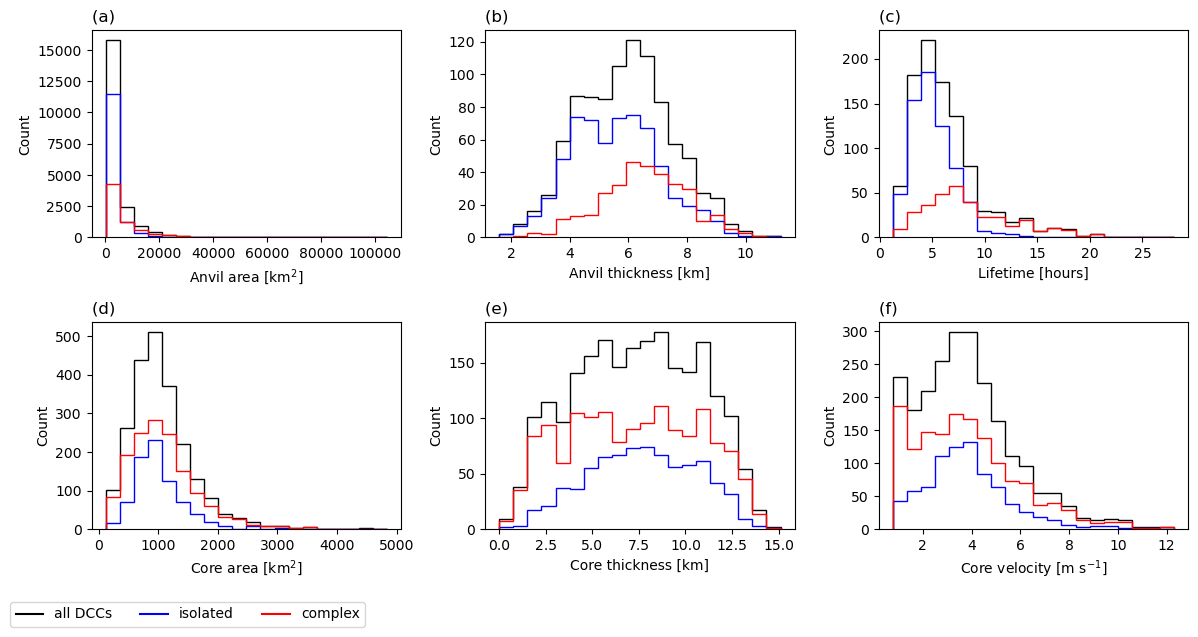

In [9]:
# histograms of key properties

def make_hists(ax, ds, v, params):
    hist, bins, _ = ax.hist(ds[v].values.ravel(), bins=20, **params) # all
    ax.hist(ds[v].where(ds.is_isolated==1).values.ravel(), bins=bins, histtype='step', ec=c2) # isolated
    ax.hist(ds[v].where(ds.is_isolated==0).values.ravel(), bins=bins, histtype='step', ec=c3) # complex    

params = dict(color='grey', histtype='step', ec=c1)
fig, axs = plt.subplots(2,3,figsize=(12,6),layout='tight')

row = axs[0,:]
for i,v in enumerate(dcc_variables):
    ax = row[i]
    make_hists(ax, ds, v, params)
    ax.set(ylabel='Count', xlabel=titles[v])

row = axs[1,:]
for i,v in enumerate(cc_variables):
    ax = row[i]
    make_hists(ax, ds, v, params)
    ax.set(ylabel='Count', xlabel=titles[v])

for i, ax in enumerate(axs.flat):
    ax.set_title(alphabet[i], loc='left')

for j,_ in enumerate(row):
    if j>i:
        row[j].axis('off')

# legend
ax.plot([],[], c=c1, label='all DCCs')
ax.plot([],[], c=c2, label='isolated')
ax.plot([],[], c=c3, label='complex')
fig.legend(loc='upper left', bbox_to_anchor=(0,0), ncols=3)

fig.savefig(savedir / f'fig09.{ext}', dpi=dpi, bbox_inches='tight')

#### figure 10 - thermodynamic heights

In [10]:
t_profile = xr.open_dataset(datadir / 'domain_mean_temperature_profile.nc')

In [11]:
# determine widths
di = {'all': [], 'iso': [], 'plx': []}
for v in ['abh', 'cth', 'core_bh', 'core_th']:
    da = ds[v].values
    isolated = ds.is_isolated.broadcast_like(ds[v]).values

    # all
    hist, _ = np.histogram(da[~np.isnan(da)], bins=50, density=True)
    di['all'].append(hist.max())

    # isolated
    mask = isolated == 1
    hist, _ = np.histogram(da[mask & ~np.isnan(da)], bins=50, density=True)
    di['iso'].append(hist.max())

    # plx
    mask = isolated == 0
    hist, _ = np.histogram(da[mask & ~np.isnan(da)], bins=50, density=True)
    di['plx'].append(hist.max())

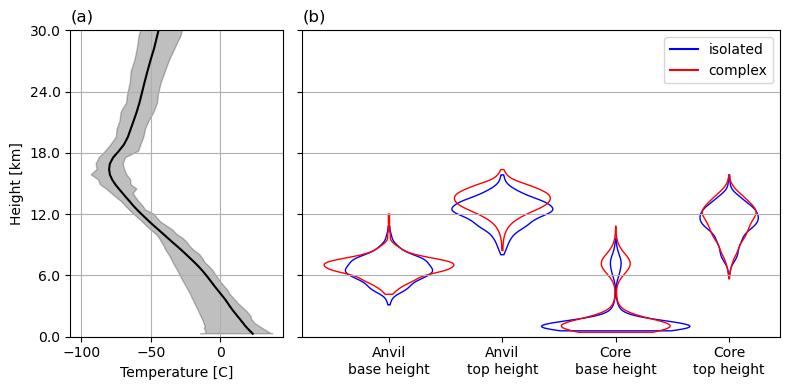

In [12]:
c1,c2,c3 = 'k','b','r'

# helpers for violin plotting
def dropnan(d, var='core_max_w'):
    vals = d[var].values
    return vals[~np.isnan(vals)]

def color_violin(parts, fc='steelblue', ec='grey', alpha=.75):        
    for part in ('cbars','cmins','cmaxes','cmedians'):
        if part in parts.keys():
            pc = parts[part]
            pc.set_edgecolor(ec)
            pc.set_alpha(alpha)
    if 'cmeans' in parts.keys():
        pc = parts['cmeans']
        pc.set_edgecolor('k')
    for i,pc in enumerate(parts['bodies']):
        pc.set_facecolor(fc[i]) if isinstance(fc, list) else pc.set_facecolor(fc)
        pc.set_edgecolor(ec)
        pc.set_alpha(alpha)

# plot

def make_pdfs(ax, ds, params, params2):
    parts = ax.violinplot([dropnan(ds, var) for var in ['abh','cth','core_bh','core_th']], (1,2,3,4), **params)
    color_violin(parts, **params2)
    
fig, axs = plt.subplots(1,2, figsize=(8,4), sharey=1, layout='tight', gridspec_kw={'width_ratios': [1, 2.25]})

ax = axs[0]
ax.plot(t_profile.ta_mean - 273.15, t_profile.z_mean, c='k', label='background atmosphere')
ax.fill_betweenx(t_profile.z_mean, t_profile.ta_min-273.15, t_profile.ta_max-273.15, color='k', alpha=.25, )
ax.set(ylabel='Height [km]', xlabel='Temperature [C]', ylim=(0,30))
ax.set_yticks(np.linspace(0,30,6), np.linspace(0,30,6))
ax.grid()
ax.set_title('(a)', loc='left')

# plot violins
ax = axs[1]

# data
w = 1
prms1 = dict(showmeans=0, showextrema=0)
prms2 = dict(fc='none', alpha=1)
# make_pdfs(ax, ds, dict(showmeans=0, widths=np.array(di['all'])*w), dict(fc='none',ec=c1))
cond = (ds.is_isolated==1)
make_pdfs(ax, ds.where(cond), prms1|{'widths':np.array(di['iso'])*w}, prms2|{'ec':c2})
make_pdfs(ax, ds.where(~cond), prms1|{'widths':np.array(di['plx'])*w}, prms2|{'ec':c3})

# decorate
ax.set_xticks((1,2,3,4),('Anvil\nbase height','Anvil\ntop height','Core\nbase height','Core\ntop height'))
ax.grid(axis='y')
ax.grid(which='minor', axis='y')
ax.set_title('(b)', loc='left')

# legend
# ax.plot([],[], c=c1, label='all DCCs')
ax.plot([],[], c=c2, label='isolated')
ax.plot([],[], c=c3, label='complex')
ax.legend(ncol=1)   
    
fig.savefig(savedir / f'fig10.{ext}', dpi=dpi, bbox_inches='tight')

#### figure 11 - typical evolution

In [13]:
def get_hist(x, bins):
    data = x.values
    data = data[~np.isnan(data)]
    hist, bins = np.histogram(data.flatten(), bins=bins, density=0)
    return xr.DataArray(hist, dims=dict(height=bins), coords=dict(height=bins[:-1], time=x.interp_time))

nbins = 10
histogram_depth = ds.cloud_depth.groupby(ds.interp_time).apply(get_hist, args=(np.linspace(0,15,nbins),))
histogram_area = ds.cloud_area.groupby(ds.interp_time).apply(get_hist, args=(np.linspace(0,1e4,nbins), ))

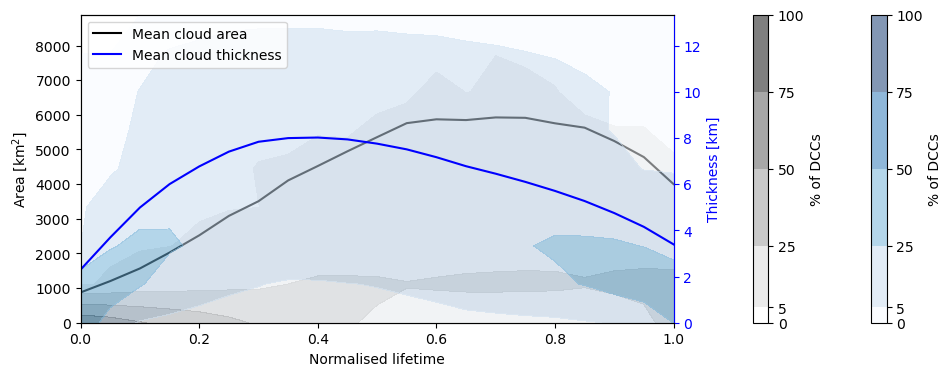

In [14]:
def plot_evolution(ax, da, lab="all DCCs", params={}, fill=0):
    mean = da.mean('system')
    std = da.std('system')
    ax.plot(da.interp_time, mean, label=lab, **params)
    if fill:
        ax.fill_between(da.interp_time, mean - std, mean + std, alpha=0.1, **params)

fig, ax = plt.subplots(figsize=(12,4))
axt = ax.twinx()
ticks = [0, .05, .25, .5, .75, 1]

# area
# c1, c1c = 'r', 'Reds'
c1, c1c = 'k', 'Greys'
pc = (histogram_area/histogram_area.sum('height')).where(histogram_area>0).plot.contourf(ax=ax, x='interp_time', y='height', cmap=c1c, alpha=.5, add_colorbar=0, levels=ticks)
da = ds.cloud_area
ax.plot(da.interp_time, da.mean('system'), label='Mean cloud '+unit_types['cloud_area'].lower(), c=c1)
# ax.plot(da.interp_time, da.median('system'), label='Median '+unit_types['cloud_area'].lower(), c='k', ls='-.')

# depth
c2, c2c = 'b', 'Blues'
pc2 = (histogram_depth/histogram_depth.sum('height')).where(histogram_depth>0).plot.contourf(ax=axt, x='interp_time', y='height', cmap=c2c, alpha=.5, add_colorbar=0, levels=ticks)
# pc2 = (histogram_depth/histogram_depth.sum('height')).where(histogram_depth>0).plot.contourf(ax=axt, x='interp_time', y='height', cmap='Blues', alpha=.5, add_colorbar=0, levels=ticks)
da = ds.cloud_depth
axt.plot(da.interp_time, da.mean('system'), label='Mean cloud '+unit_types['cloud_depth'].lower(), c=c2)
# axt.plot(da.interp_time, da.median('system'), label='Median '+unit_types['cloud_depth'].lower(), c=c2, ls='-.')

# cbars
cbar1 = fig.colorbar(pc2, ax=ax, pad=.0, spacing='proportional', label='% of DCCs')
cbar2 = fig.colorbar(pc, ax=ax, pad=.1, spacing='proportional', label='% of DCCs')
cbar1.set_ticklabels((np.array(ticks)*100).astype(int))
cbar2.set_ticklabels((np.array(ticks)*100).astype(int))

# decorate
ax.set(ylim=(0,None))
axt.set(ylim=(0,None))
ax.set(xlabel='Normalised lifetime', ylabel=labels['cloud_area'])
axt.set(ylabel=labels['cloud_depth'])
fig.legend(loc='upper left', bbox_to_anchor=(.125,.88), ncol=1)
my_tools.color_axis(axt,c2,pad=0)

fig.savefig(savedir / f'fig11.{ext}', dpi=dpi, bbox_inches='tight')

#### figure 12 - convective core overview

In [15]:
# bins to use to group each variable
def use_quantiles(ds,v):
    return ds.mean('core')[v].compute().quantile((0,.25,.5,.75,1)).values
bins = {'core_area': use_quantiles(ds, 'core_area'),
        'core_max_w': use_quantiles(ds, 'core_max_w'),
        'n_cores': [0,1,2,3,5,10,ds.n_cores.max().compute().item()],}
def make_labs(var):
    labs = []
    for n in range(len(bins[var])-1):
        labs.append(f"[{bins[var][n]:.1f}, {bins[var][n+1]:.1f})")
    return labs
bin_labels = {'n_cores':['1','2','3','4-5','6-10','10+']} | {k:make_labs(k) for k in bins.keys() if k != 'n_cores'}

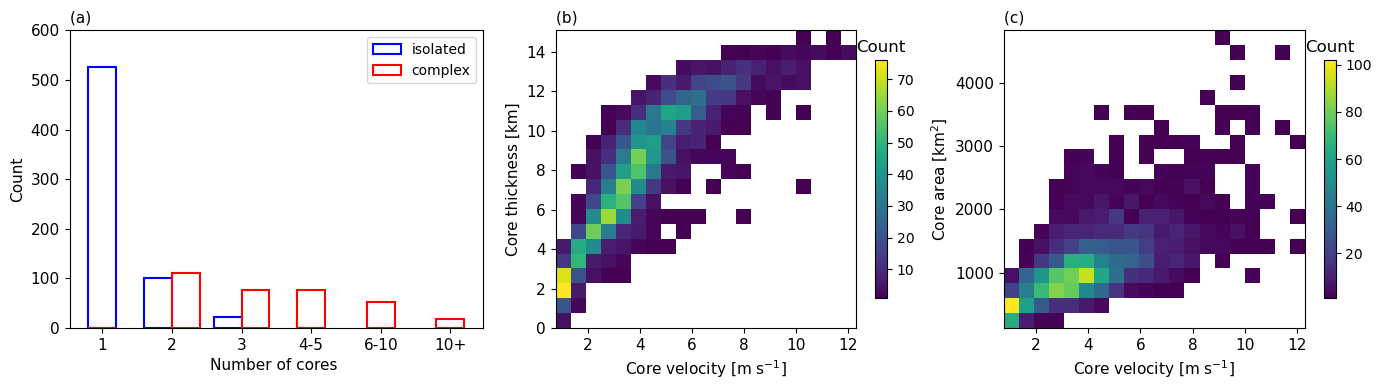

In [18]:
def plot_cores_hist(ax, ds, params={}, shift=0):
    counts, _ = np.histogram(ds.n_cores, bins=[x+1 for x in bins['n_cores']])
    x = np.arange(len(counts))
    w = .9-np.max(np.abs(shift))
    ax.bar(x+w*shift, counts, width=w, **params)
    ax.set_xticks(x)
    ax.set_xticklabels(bin_labels['n_cores'])
    return counts

cmap = plt.get_cmap('viridis')
cmap.set_under('none')
hist_params = dict(cmap=cmap, vmin=.9)

fsize=11
fig, axs = plt.subplots(1,3, figsize=(14, 4), gridspec_kw={'width_ratios':[1.1,1,1]}, layout='tight')

d1 = ds.where(ds.is_isolated==1)
d2 = ds.where(ds.is_isolated==0)

ax = axs[0]
params = dict(alpha=1, lw=1.5)
counts = plot_cores_hist(ax, d1, params|dict(fc='none', ec=c2, label='isolated'), shift=np.array([0,-.5,-.5,0,0,0]))
plot_cores_hist(ax, d2, params|dict(fc='none', ec=c3, label='complex', ), shift=np.array([0,.5,.5,0,0,0]))
ax.legend()
ax.set_ylim((0,600))
ax.set_xlabel(titles['n_cores'], fontsize=fsize)
ax.set_ylabel(ylabel='Count', fontsize=fsize)
ax.set_title(alphabet[0], loc='left', fontsize=fsize)
ax.tick_params(labelsize=fsize)

# last
d = ds.max('system').dropna('core',how='any')
ordered_vars = (('core_max_w','core_depth'),('core_max_w','core_area'))
for i,ax in enumerate(axs[1:]):
    x,y = ordered_vars[i]
    X = d[x].values.flatten()
    Y = d[y].values.flatten()
    hist = ax.hist2d(X[~np.isnan(X)], Y[~np.isnan(Y)], bins=(20,20), **hist_params)
    ax.set_xlabel(titles[x], fontsize=fsize)
    ax.set_ylabel(titles[y], fontsize=fsize)
    cb = plt.colorbar(hist[3], ax=ax, label=None, shrink=.8, )
    cb.ax.set_title('Count')
    ax.set_title(alphabet[i+1], loc='left', fontsize=fsize)
    ax.tick_params(labelsize=fsize)


fig.savefig(savedir / f'fig12.{ext}', dpi=300, bbox_inches='tight')

#### figure 13 - bulk relationships

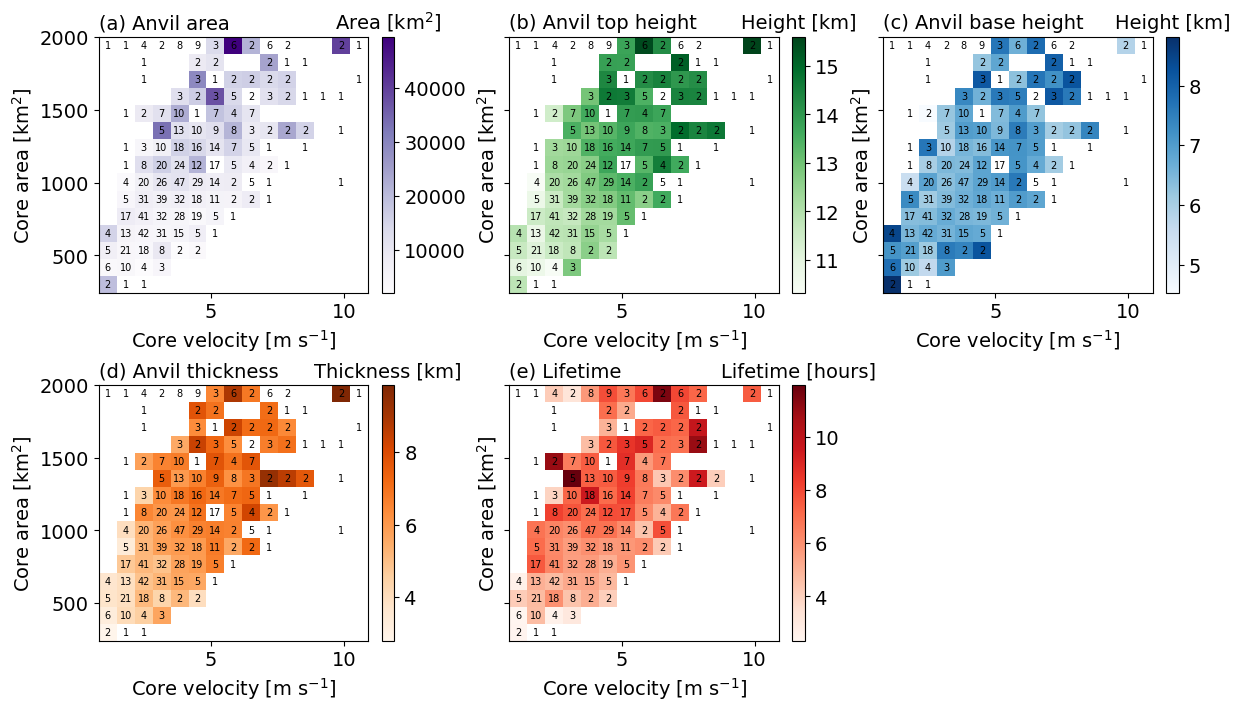

In [21]:
## cloud properties by organisation+complexity - stacked fig

nbins = 15
min_nvals = 2
ccmap = ('Purples','Greens','Blues','Oranges','Reds')

fig, axs = plt.subplots(2,3, figsize=(12,7), layout='constrained', sharey=1)

fsize = 14
d = ds
x, y = 'core_max_w', 'core_area'
x_vals, y_vals = d[x].mean('core'), d[y].mean('core')
y_vals = y_vals.where(y_vals<2000, 2000)

c_vars = ['cloud_area','cth','abh','anvil_depth','lifetime_hours',]

for i,ax in enumerate(axs.flat):
    if i>4:
        continue
    # calculate c value in each bin
    c = c_vars[i]
    c_vals = d[c]
    if 'interp_time' in c_vals.dims:
        # this will only apply to cloud area and cloud depth
        c_vals = c_vals.max('interp_time')
    stat, X, Y, _ = scipy.stats.binned_statistic_2d(x_vals, y_vals, c_vals, statistic='mean', bins=(nbins,nbins))
    # mask stat to where sufficient data points
    hist = np.histogram2d(x_vals, y_vals, bins=nbins,)[0]
    stat = np.ma.masked_where(hist < min_nvals, stat).filled(np.nan)
    # view
    pcm = ax.pcolormesh(X, Y, stat.transpose(), cmap=ccmap[i])
    # decorate
    ax.set_ylabel(titles[y], fontsize=fsize)
    ax.set_xlabel(titles[x], fontsize=fsize)
    cb = plt.colorbar(pcm, ax=ax, shrink=1, )
    cb.ax.set_title(labels[c], fontsize=fsize)
    cb.ax.tick_params(labelsize=fsize)
    ax.set_title(alphabet[i]+f"{names[c]}", loc='left', fontsize=fsize)
    ax.tick_params(labelsize=fsize)
    # annotate
    for xi in range(len(X)-1):
        for yi in range(len(Y)-1):
            count = int(hist[xi, yi])
            if count > 0:  # only label non-empty bins
                ax.text(
                    (X[xi] + X[xi+1]) / 2,    # x-center
                    (Y[yi] + Y[yi+1]) / 2,    # y-center
                    str(count),
                    ha='center', va='center',
                    fontsize=7, color='black'
                )
axs.flat[1].set_title('(b) Anvil top height', loc='left', fontsize=fsize)
axs.flat[-1].axis('off')

fig.savefig(savedir / f'fig13.{ext}', bbox_inches='tight', dpi=dpi)


#### figure 14 - evolution by convective characteristics

In [22]:
def double_groupby(ds, first, second, bins_first="percentile", bins_second="percentile"):
    def inner_func(subset):
        # choose bins for second variable
        if bins_second == "percentile":
            pi = subset[second].quantile((0, 0.5, 1)).values
        else:
            pi = bins_second
        grouped = subset.groupby_bins(subset[second], bins=pi).mean()
        return grouped
    if bins_first == "percentile":
        pi = ds[first].quantile((0, 0.5, 1)).values
    else:
        pi = bins_first
    return ds.groupby_bins(ds[first], bins=pi).apply(inner_func)

In [23]:
gds = xr.Dataset({
    "A": ds.cloud_area,
    "w": ds.core_max_w.mean("core"),
    "Ac": ds.core_area.mean("core"),
}).compute()

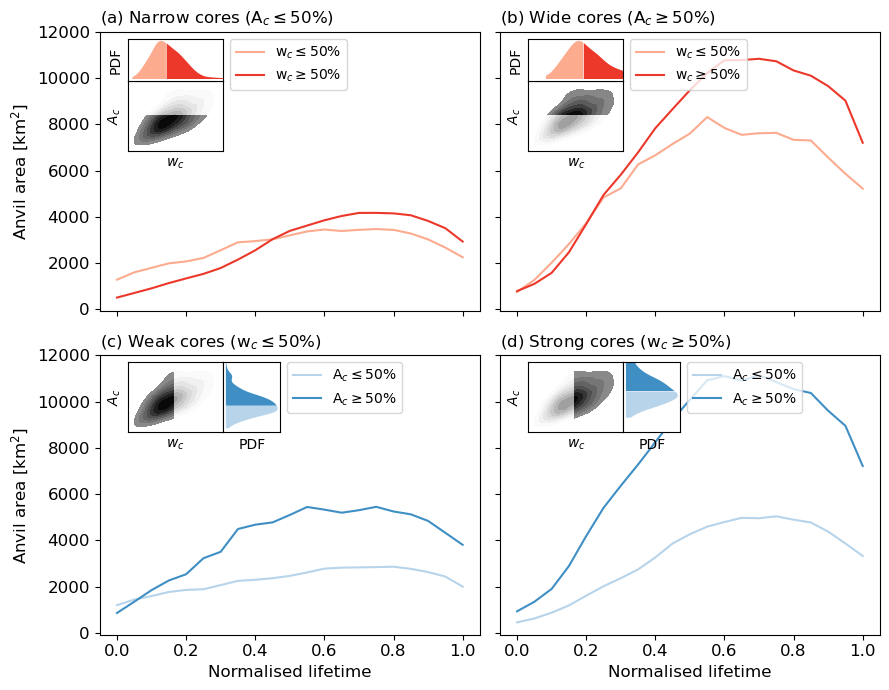

In [24]:
wlims = (.5,7)
aclims = (150,1750)

def calc_2d_pdf(X, Y, n=200):
    x_vals = np.linspace(np.min(X), np.max(X), n)
    y_vals = np.linspace(np.min(Y), np.max(Y), n)
    xx, yy = np.meshgrid(x_vals, y_vals)
    pdf_vals = np.reshape(scipy.stats.gaussian_kde(np.vstack([X, Y]))(np.vstack([xx.ravel(), yy.ravel()])), xx.shape)
    return xx, yy, pdf_vals

def plot_2d_inset(ax, X, Y, mask='x', restrict='lower'):
    xx, yy, pdf_vals = calc_2d_pdf(X, Y)
    if mask=='x':
        median_val = np.median(X)
        masked_pdf = np.where(xx<=median_val, pdf_vals, np.nan) if restrict=='lower' else np.where(xx>=median_val, pdf_vals, np.nan)
        masked_remaining = Y[X<=median_val] if restrict=='lower' else Y[X>=median_val]
    elif mask=='y':
        median_val = np.median(Y)
        masked_pdf = np.where(yy<=median_val, pdf_vals, np.nan) if restrict=='lower' else np.where(yy>=median_val, pdf_vals, np.nan)
        masked_remaining = X[Y<=median_val] if restrict=='lower' else X[Y>=median_val]
    cmap_low = mpl.colors.ListedColormap(plt.get_cmap('Greys')(np.linspace(0, .5, 256))); cmap_low.set_under('none')
    cmap_high = mpl.colors.ListedColormap(plt.get_cmap('Greys')(np.linspace(.5, 1, 256))); cmap_high.set_under('none')
    ax.contourf(xx, yy, pdf_vals, cmap=cmap_low, vmin=5e-5)
    ax.contourf(xx, yy, masked_pdf, cmap=cmap_high, vmin=5e-5)
    ax.set(xlim=wlims, ylim=aclims, xticks=[], yticks=[], ylabel=r'$A_c$', xlabel=r'$w_c$')
    return masked_remaining

def plot_1d_inset(ax, X, cmap, label='', rotation='vertical'):
    x_vals = np.linspace(np.min(X), np.max(X), 200)
    pdf_vals = scipy.stats.gaussian_kde(X)(x_vals)
    p = np.median(X)
    if rotation == 'vertical':
        ax.fill_between(x_vals, 0, pdf_vals, where=(x_vals <= p), fc=cmap[0])
        ax.fill_between(x_vals, 0, pdf_vals, where=(x_vals >= p), fc=cmap[1])
        ax.set_xlabel(label); ax.set_ylabel("PDF")
        if np.max(X)>100:
            ax.set(xlim=aclims, xticks=[], yticks=[])
        else:
            ax.set(xlim=wlims, xticks=[], yticks=[])
    else:
        ax.fill_betweenx(x_vals, 0, pdf_vals, where=(x_vals <= p), fc=cmap[0])
        ax.fill_betweenx(x_vals, 0, pdf_vals, where=(x_vals >= p), fc=cmap[1])
        ax.set_ylabel(label); ax.set_xlabel("PDF")
        if np.max(X)>100:
            ax.set(ylim=aclims, xticks=[], yticks=[])
        else:
            ax.set(ylim=wlims, xticks=[], yticks=[])

# ----------------------
# Main plotting
# ----------------------
vorders = (("Ac","w"),("w","Ac"),)  # first row = (w, Ac), second row = (Ac, w)
cmaps = ('Reds',"Blues",)
# labs = ("below median","above median")
labs = (r'$_c\leq$',r'$_c\geq$') 
name_map = {'w':'core_max_w','Ac':'core_area'}
title = ['Narrow','Wide','Weak','Strong']
fsize = 12

fig, axs = plt.subplots(2, 2, figsize=(9,7), layout="tight", sharey=True, sharex=True)

# Line plots
count = 0
for k, row in enumerate(axs):
    first, second = vorders[k]
    data = double_groupby(gds, first, second)
    cmap = plt.get_cmap(cmaps[k])
    
    for i, fbin in enumerate(data[f"{first}_bins"]):
        ax = row[i]
        sub = data.sel({f"{first}_bins": fbin}).dropna(f"{second}_bins", how="all")
        for j, sbin in enumerate(sub[f"{second}_bins"]):
            d = sub.sel({f"{second}_bins": sbin})
            c = cmap(j/3+0.3)
            ax.plot(d.interp_time, d.A, c=c, label=f"{second[0]}{labs[j]}50%")
        ax.set_title(alphabet[count] + f"{title[count]} cores ({first[0]}{labs[i]}50%)", loc='left', fontsize=fsize)
        # ax.set_title(alphabet[count] + f"DCCs with {first[0]}{labs[i]}50% only", loc='left', fontsize=fsize)
        if k: ax.set_xlabel('Normalised lifetime', fontsize=fsize)
        if not i: ax.set_ylabel(titles['cloud_area'], fontsize=fsize)
        ax.tick_params(labelsize=fsize)
        count += 1

# Inset axes using vorders
d = ds[['core_max_w','core_area']].mean('core').dropna('system')
var_map = {'w': d['core_max_w'].values.flatten(), 'Ac': d['core_area'].values.flatten()}

# top row
for i, ax in enumerate(axs[1]):
    first, second = vorders[0]
    colors = [plt.get_cmap(cmaps[1])(0/3+0.3), plt.get_cmap(cmaps[1])(1/3+0.3)]
    axins2d = ax.inset_axes([0.075, .725, 0.25, 0.25])
    axins1d = ax.inset_axes([0.325, .725, 0.15, 0.25])
    masked_remaining = plot_2d_inset(axins2d, var_map['w'], var_map['Ac'], mask='x', restrict=['lower',''][i])
    plot_1d_inset(axins1d, masked_remaining, colors, label='', rotation='horizontal')
    ax.legend(loc='upper left', bbox_to_anchor=(0.475,1))

# bottom row
for i, ax in enumerate(axs[0]):
    first, second = vorders[1]
    colors = [plt.get_cmap(cmaps[0])(0/3+0.3), plt.get_cmap(cmaps[0])(1/3+0.3)]
    axins2d = ax.inset_axes([0.075, .575, 0.25, 0.25])
    axins1d = ax.inset_axes([0.075, .825, 0.25, 0.15])
    masked_remaining = plot_2d_inset(axins2d, var_map['w'], var_map['Ac'], mask='y', restrict=['lower',''][i])
    plot_1d_inset(axins1d, masked_remaining, colors, label='', rotation='vertical')
    ax.legend(loc='upper left', bbox_to_anchor=(0.325,1))

for ax in axs.flat:
    ax.set_ylim(None, 12000)

fig.savefig(savedir / f'fig14.{ext}', bbox_inches='tight', dpi=dpi)